In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing
%matplotlib inline

In [2]:
numdays = 365*10 + 2
base = '2010-01-01'
base = datetime.strptime(base, '%Y-%m-%d')
date_list = [base + timedelta(days=x) for x in range(numdays)]
date_list = np.array(date_list)
print(len(date_list), date_list[0], date_list[-1])


x = np.linspace(-np.pi, np.pi, 365)
temp_year = (np.sin(x) + 1.0) * 15
x = np.linspace(-np.pi, np.pi, 366)
temp_leap_year = (np.sin(x) + 1.0)
temp_s = []
for i in range(2010, 2020):
    if i == 2010:
        temp_s = temp_year + np.random.rand(365) * 20
    elif i in [2012, 2016]:
        temp_s = np.concatenate((temp_s, temp_leap_year * 15 + np.random.rand(366) * 20 + i % 2010))
    else:
        temp_s = np.concatenate((temp_s, temp_year + np.random.rand(365) * 20 + i % 2010))
print(len(temp_s))


data = np.concatenate((date_list.reshape(-1, 1), temp_s.reshape(-1, 1)), axis=1)
df_orig = pd.DataFrame(data, columns=['date', 'temp'])
df_orig['date'] =  pd.to_datetime(df_orig['date'], format='%Y-%m-%d')
df = df_orig.set_index('date')
df.sort_index(inplace=True)
df

3652 2010-01-01 00:00:00 2019-12-31 00:00:00
3652


,temp
date,
2010-01-01,29.7302
2010-01-02,32.1106
2010-01-03,27.3102
2010-01-04,20.9969
2010-01-05,27.272
...,...
2019-12-27,25.427
2019-12-28,26.0683
2019-12-29,43.3912


In [3]:
df.dtypes

temp    object
dtype: object

In [4]:
df.index.dtype

dtype('<M8[ns]')

Text(0, 0.5, 'temperature')

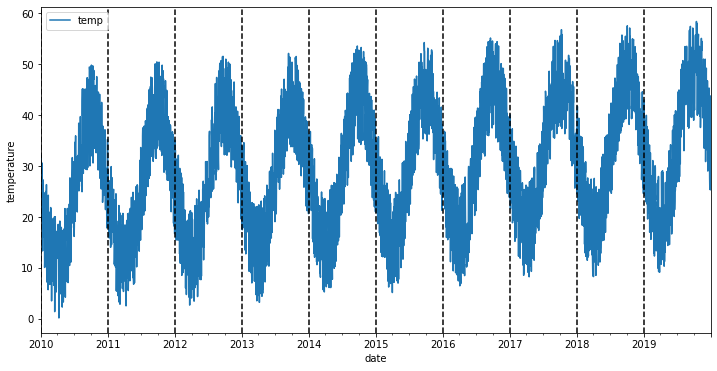

In [5]:
ax = df_orig.plot(x='date', y='temp', figsize=(12,6))
xcoords = ['2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
           '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
ax.set_ylabel('temperature')

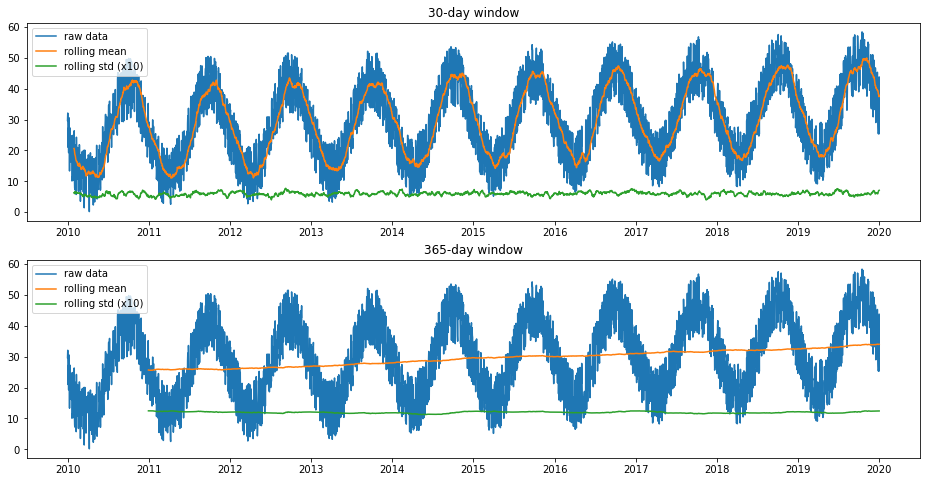

In [8]:
def analyze_stationarity(timeseries, title):
    fig, ax = plt.subplots(2, 1, figsize=(16, 8))

    rolmean = pd.Series(timeseries).rolling(window=30).mean() 
    rolstd = pd.Series(timeseries).rolling(window=30).std()
    ax[0].plot(timeseries, label= title)
    ax[0].plot(rolmean, label='rolling mean');
    ax[0].plot(rolstd, label='rolling std (x10)');
    ax[0].set_title('30-day window')
    ax[0].legend()
    
    rolmean = pd.Series(timeseries).rolling(window=365).mean() 
    rolstd = pd.Series(timeseries).rolling(window=365).std()
    ax[1].plot(timeseries, label= title)
    ax[1].plot(rolmean, label='rolling mean');
    ax[1].plot(rolstd, label='rolling std (x10)');
    ax[1].set_title('365-day window')
    ax[1].legend()
pd.options.display.float_format = '{:.8f}'.format
analyze_stationarity(df['temp'], 'raw data')


In [9]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

ADF_test(df)

Results of Dickey-Fuller Test:
Test Statistic                  -3.61516750
p-value                          0.00547759
Lags Used                       30.00000000
Number of Observations Used   3621.00000000
Critical Value (1%)             -3.43215722
Critical Value (5%)             -2.86233853
Critical Value (10%)            -2.56719507
dtype: float64


In [10]:
def KPSS_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries.dropna(), regression="c", nlags="auto")    
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

KPSS_test(df)

Results of KPSS Test:
Test Statistic           0.96450681
p-value                  0.01000000
Lags Used               37.00000000
Critical Value (10%)     0.34700000
Critical Value (5%)      0.46300000
Critical Value (2.5%)    0.57400000
Critical Value (1%)      0.73900000
dtype: float64


C:\Users\fatih\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Results of Dickey-Fuller Test:
Test Statistic                  -3.32402471
p-value                          0.01383813
Lags Used                       29.00000000
Number of Observations Used   3258.00000000
Critical Value (1%)             -3.43235874
Critical Value (5%)             -2.86242754
Critical Value (10%)            -2.56724246
dtype: float64


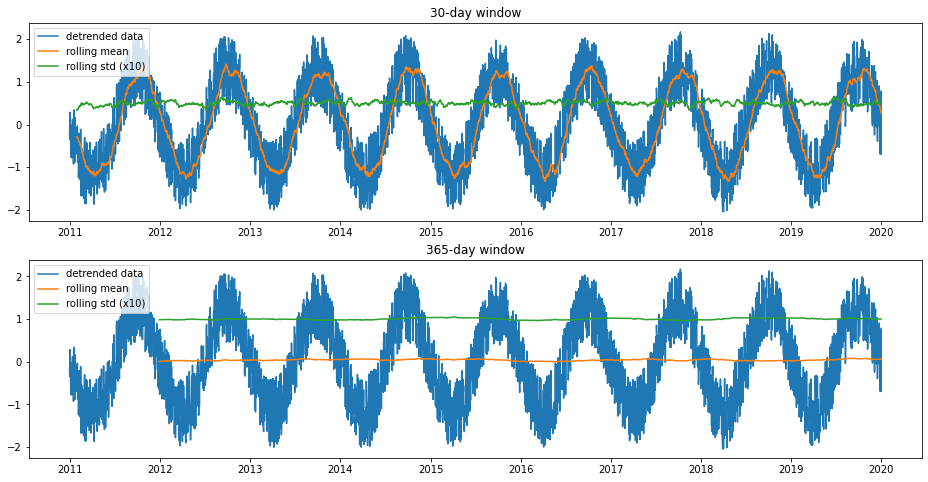

In [11]:
df_detrend = (df - df.rolling(window=365).mean()) / df.rolling(window=365).std()

analyze_stationarity(df_detrend['temp'].dropna(), 'detrended data')
ADF_test(df_detrend.dropna())

Results of Dickey-Fuller Test:
Test Statistic                 -27.22067077
p-value                          0.00000000
Lags Used                        4.00000000
Number of Observations Used   3282.00000000
Critical Value (1%)             -3.43234403
Critical Value (5%)             -2.86242105
Critical Value (10%)            -2.56723900
dtype: float64


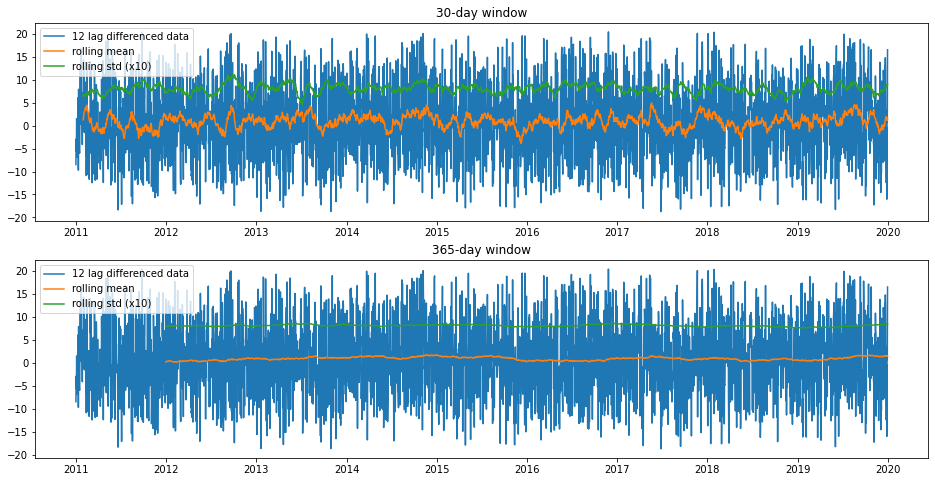

In [12]:
df_365lag =  df - df.shift(365)

analyze_stationarity(df_365lag['temp'].dropna(), '12 lag differenced data')
ADF_test(df_365lag.dropna())

Results of Dickey-Fuller Test:
Test Statistic                 -52.30524993
p-value                          0.00000000
Lags Used                        0.00000000
Number of Observations Used   2922.00000000
Critical Value (1%)             -3.43258992
Critical Value (5%)             -2.86252965
Critical Value (10%)            -2.56729682
dtype: float64


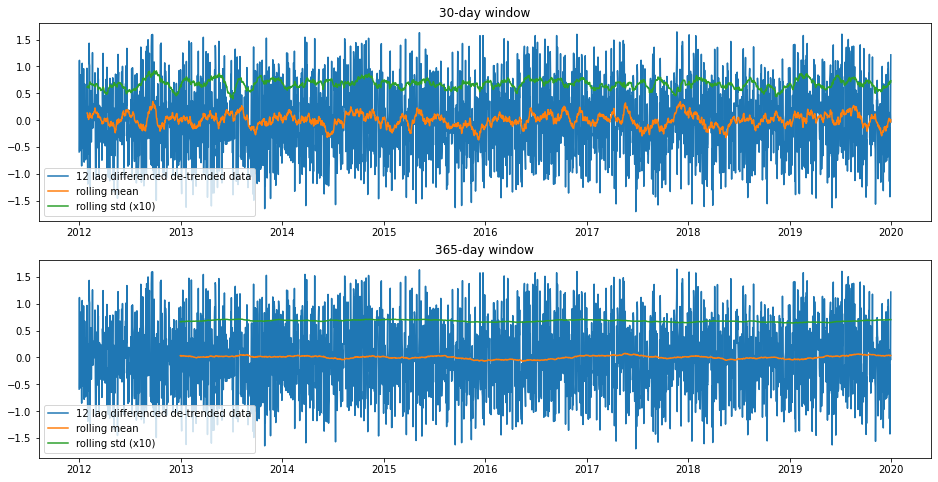

In [13]:
df_365lag_detrend =  df_detrend - df_detrend.shift(365)

analyze_stationarity(df_365lag_detrend['temp'].dropna(), '12 lag differenced de-trended data')
ADF_test(df_365lag_detrend.dropna())

<ipython-input-14-0a9a1f7dc4ae>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = sm.tsa.seasonal_decompose(df, model='additive', freq=365)


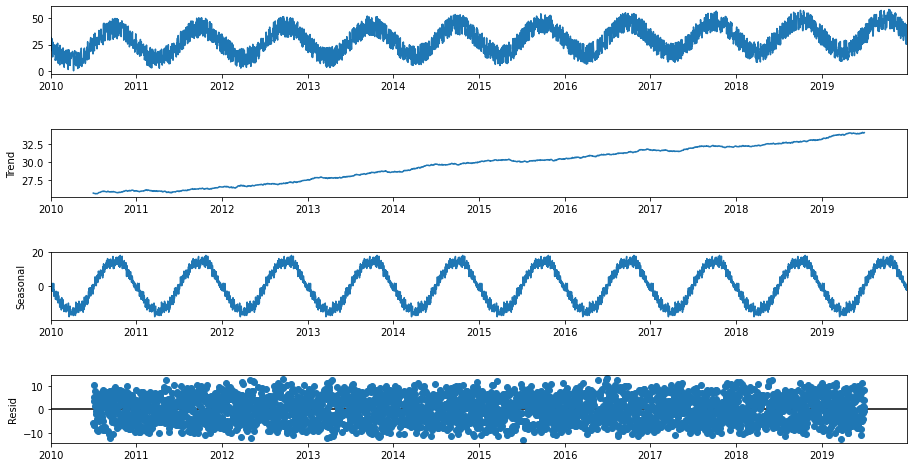

(date
 2010-01-01   nan
 2010-01-02   nan
 2010-01-03   nan
 2010-01-04   nan
 2010-01-05   nan
               ..
 2019-12-27   nan
 2019-12-28   nan
 2019-12-29   nan
 2019-12-30   nan
 2019-12-31   nan
 Name: trend, Length: 3652, dtype: float64,
 date
 2010-01-01   -0.19189793
 2010-01-02   -0.78699443
 2010-01-03   -2.62568732
 2010-01-04   -1.16387112
 2010-01-05   -1.36643306
                  ...    
 2019-12-27   -1.83212082
 2019-12-28    0.89687452
 2019-12-29   -2.29668700
 2019-12-30   -0.19189793
 2019-12-31   -0.78699443
 Name: seasonal, Length: 3652, dtype: float64,
 date
 2010-01-01   nan
 2010-01-02   nan
 2010-01-03   nan
 2010-01-04   nan
 2010-01-05   nan
               ..
 2019-12-27   nan
 2019-12-28   nan
 2019-12-29   nan
 2019-12-30   nan
 2019-12-31   nan
 Name: resid, Length: 3652, dtype: float64)

In [14]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', freq=365)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual
   
seasonal_decompose(df)

In [15]:
y = df['temp'].astype(float)
y_to_train = y[:'2017-12-31']
y_to_val = y['2018-01-01':]
predict_date = len(y) - len(y[:'2017-12-31'])

C:\Users\fatih\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\fatih\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


The Root Mean Squared Error of additive trend, additive seasonal of period season_length=365 and a Box-Cox transformation 39.58


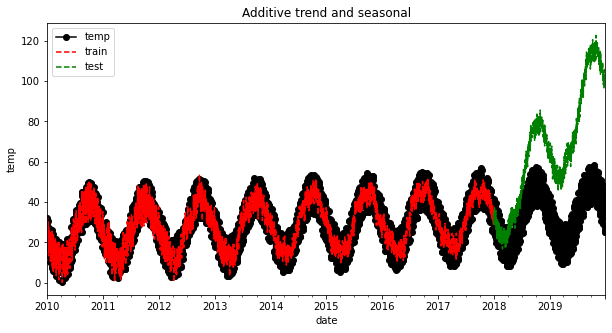

In [16]:
def holt_win_sea(y, y_to_train, y_to_test, seasonal_period, predict_date):
    
    fit1 = ExponentialSmoothing(y_to_train, seasonal_periods=seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
    fcast1 = fit1.forecast(predict_date).rename('Additive')
    mse1 = ((fcast1 - y_to_test.values) ** 2).mean()
    print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
          'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))

    y.plot(marker='o', color='black', legend=True, figsize=(10, 5))
    fit1.fittedvalues.plot(style='--', color='red', label='train')
    fcast1.plot(style='--', color='green', label='test')
    plt.ylabel('temp')
    plt.title('Additive trend and seasonal')
    plt.legend()
    plt.show()
    
holt_win_sea(y, y_to_train, y_to_val, 365, predict_date)